# 초기 환경 셋팅

In [1]:
! pip install -r requirements.txt

  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached aiohttp-3.8.5-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (973 kB)
  Using cached aiosignal-1.2.0-py3-none-any.whl (8.2 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
  Using cached asttokens-2.4.1-py2.py3-none-any.whl (27 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
ERROR: Could not find a version that satisfies the requirement attrs==23.1.0 (from versions: 15.0.0a1, 15.0.0, 15.1.0, 15.2.0, 16.0.0, 16.1.0, 16.2.0, 16.3.0, 17.1.0, 17.2.0, 17.3.0, 17.4.0, 18.1.0, 18.2.0, 19.1.0, 19.2.0, 19.3.0, 20.1.0, 20.2.0, 20.3.0, 21.1.0, 21.2.0, 21.3.0, 21.4.0, 22.1.0, 22.2.0)
ERROR: No matching distribution found for attrs==23.1.0


In [2]:
! pip install numpy==1.23.4

ERROR: Could not find a version that satisfies the requirement numpy==1.23.4 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5)
ERROR: No matching distribution found for numpy==1.23.4


In [3]:
import tensorflow as tf

if tf.test.is_gpu_available():
    print("GPU is available")
else:
    print("GPU is not available")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


# import library

In [4]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, Conv2D, LeakyReLU, BatchNormalization, Conv2DTranspose, Activation, Dropout, Add, UpSampling2D
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from skimage import exposure
import os
import time
from tensorflow.keras.callbacks import TensorBoard

In [5]:
current_time = time.strftime("%m%d_%H%M")

result_dir = os.path.join(os.getcwd(), 'result', f'logs_2x2_{current_time}')
os.makedirs(result_dir, exist_ok=True)

log_dir = os.path.join(os.getcwd(), 'logs', f'logs_2x2_{current_time}')
os.makedirs(log_dir, exist_ok=True)

print(f'Result directory created: {result_dir}')
print(f'log directory created: {log_dir}')

Epoch = 300
batch = 32

Result directory created: /jsm0707/GAN/result/logs_2x2_0808_0839
log directory created: /jsm0707/GAN/logs/logs_2x2_0808_0839


# Data load

(864, 256, 256) (864, 256, 256)


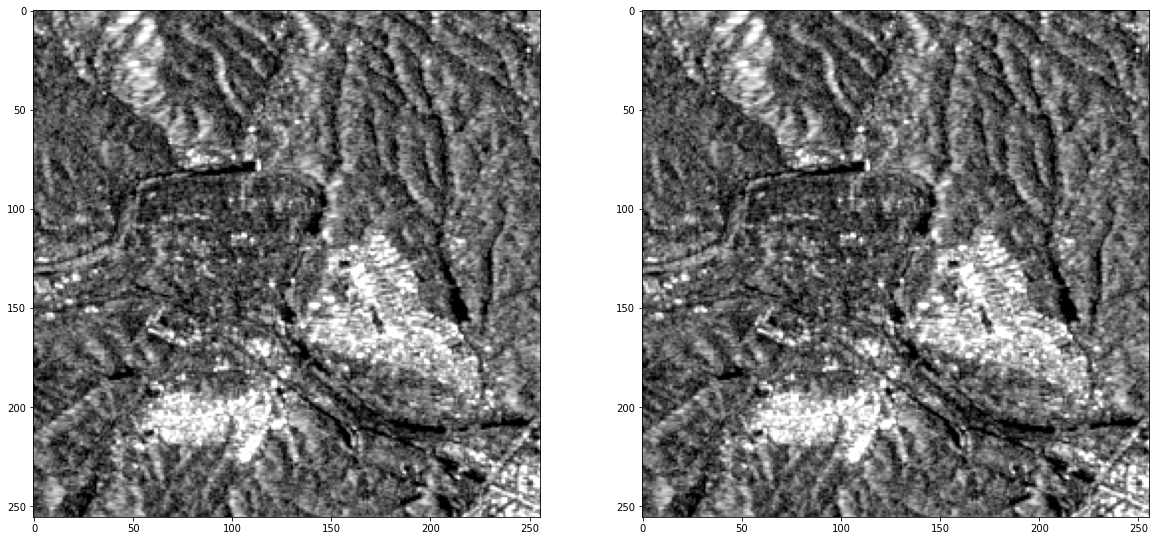

In [6]:
def load_tif_files(directory, target_size=(256, 256)):
    files = sorted([os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.tif')])
    data = []
    for file in files:
        img = tiff.imread(file)
        img_resized = cv2.resize(img, target_size)
        data.append(img_resized)
    return np.array(data)

def load_dataset(x_directory, y_directory):
    x_data = load_tif_files(x_directory)
    y_data = load_tif_files(y_directory)
    return x_data, y_data

def contrast(image): 
    valid_data = image[np.logical_and(image != np.inf, image != -np.inf)] 
    in_low, in_high = np.percentile(valid_data, (2, 98))
    image = exposure.rescale_intensity(image, in_range=(in_low, in_high))
    return image


x_directory = os.path.join(os.getcwd(), 'test_image', 'subset_512_2x2')
y_directory = os.path.join(os.getcwd(), 'test_image', 'subset_512')
X, y = load_dataset(x_directory, y_directory)
print(X.shape, y.shape)

fig, axs = plt.subplots(1, 2, figsize=(20, 15))
axs[0].imshow(contrast(X[0]), cmap='gray')
axs[1].imshow(contrast(y[0]), cmap='gray')
plt.show()

# Define Discriminator

In [7]:
def load_data(batch_size):
    i = np.random.randint(0, int(len(X) / batch_size))
    img_A = (np.array(X[i:i + batch_size]) / 5000.0) - 1
    img_B = (np.array(y[i:i + batch_size]) / 5000.0) - 1
    return img_A, img_B

def load_batch(batch_size):
    for i in range(int(len(X) / batch_size)):
        img_A = (X[i:i + batch_size] / 5000.0) - 1
        img_B = (y[i:i + batch_size] / 5000.0) - 1
        yield img_A, img_B

def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    in_src_image = Input(shape=image_shape)
    in_target_image = Input(shape=image_shape)
    merged = Concatenate()([in_src_image, in_target_image])
    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    patch_out = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(patch_out)
    model = Model([in_src_image, in_target_image], patch_out)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model


# Define Generator

In [8]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    if g.shape[1] != skip_in.shape[1] or g.shape[2] != skip_in.shape[2]:
        skip_in = UpSampling2D(size=(g.shape[1] // skip_in.shape[1], g.shape[2] // skip_in.shape[2]))(skip_in)
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

def residual_block(layer_in, n_filters, kernel_size=(3,3)):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, kernel_size, padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    g = Activation('relu')(g)
    g = Conv2D(n_filters, kernel_size, padding='same', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)
    g = Add()([g, layer_in])
    return g

def define_generator(image_shape):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    r1 = residual_block(b, 512)
    r2 = residual_block(r1, 512)
    r3 = residual_block(r2, 512)
    d1 = decoder_block(r3, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    g = Conv2DTranspose(image_shape[-1], (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    model = Model(in_image, out_image)
    return model

# Define Gan

In [9]:
def define_gan(g_model, d_model, image_shape):
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    in_src = Input(shape=image_shape)
    gen_out = g_model(in_src)
    dis_out = d_model([in_src, gen_out])
    model = Model(in_src, [dis_out, gen_out])
    opt = Adam(learning_rate=0.0001, beta_1=0.5)  # 학습률을 0.0002에서 0.0001로 낮춤
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
    return model

In [10]:
def generate_real_samples(n_samples, patch_shape):
    trainA, trainB = load_data(n_samples)
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [11]:

def summarize_performance(step, g_model, result_dir, n_samples):
    r, c = 3, n_samples
    [X_realA, X_realB], _ = generate_real_samples(n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    gen_imgs = [X_realA, X_fakeB, X_realB]
    titles = ['Condition', 'Generated', 'Original']
    fig, axs = plt.subplots(r, c, figsize=(20, 20))
    for i in range(r):
        for j in range(c):
            image = gen_imgs[i][j]
            rescaled_image = (image + 1) * 5000
            axs[i, j].imshow(contrast(rescaled_image / 10000), cmap='gray')
            axs[i, j].set_title(titles[i])
            axs[i, j].axis('off')
    filename = '%s/plot_%06d.png' % (result_dir, step)
    fig.savefig(filename)
    plt.close(fig)

# Training

In [12]:
tensorboard_callback = TensorBoard(log_dir=log_dir)
file_writer = tf.summary.create_file_writer(log_dir)

def train(d_model, g_model, gan_model, n_epochs, n_batch, result_dir, d_filename, g_filename, file_writer, update_ratio=5):
    n_patch = d_model.output_shape[1]
    for epoch in range(1, n_epochs + 1):
        for batch_i, (trainA, trainB) in enumerate(load_batch(n_batch)):
            [X_realA, X_realB], y_real = generate_real_samples(n_batch, n_patch)
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

            # Update discriminator more frequently
            if batch_i % update_ratio == 0:
                d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
                d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
                with file_writer.as_default():
                    tf.summary.scalar('D1_loss', d_loss1, step=epoch)
                    tf.summary.scalar('D2_loss', d_loss2, step=epoch)
            
            # Always update generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
            with file_writer.as_default():
                tf.summary.scalar('G_loss', g_loss, step=epoch)

        summarize_performance(epoch, g_model, result_dir, n_samples=3)
        print('[Epoch %d] D1_loss: %.3f, D2_loss: %.3f, G_loss: %.3f' % (epoch, d_loss1, d_loss2, g_loss))
        g_model.save(g_filename)
        d_model.save(d_filename)

image_shape = (X.shape[1], X.shape[2], 1)
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
g_filename = os.path.join(result_dir, 'g_model.h5')
d_filename = os.path.join(result_dir, 'd_model.h5')
if os.path.exists(g_filename):
    g_model.load_weights(g_filename)
if os.path.exists(d_filename):
    d_model.load_weights(d_filename)
gan_model = define_gan(g_model, d_model, image_shape)
train(d_model, g_model, gan_model, n_epochs=Epoch, n_batch=batch, result_dir=result_dir, d_filename=d_filename, g_filename=g_filename, file_writer=file_writer)


[Epoch 1] D1_loss: 0.099, D2_loss: 0.347, G_loss: 60.917


/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


[Epoch 2] D1_loss: 0.024, D2_loss: 0.024, G_loss: 38.725
[Epoch 3] D1_loss: 1.505, D2_loss: 0.150, G_loss: 22.349
[Epoch 4] D1_loss: 0.563, D2_loss: 0.429, G_loss: 13.108
[Epoch 5] D1_loss: 0.406, D2_loss: 0.417, G_loss: 8.780
[Epoch 6] D1_loss: 0.399, D2_loss: 0.406, G_loss: 6.362
[Epoch 7] D1_loss: 0.394, D2_loss: 0.401, G_loss: 4.791
[Epoch 8] D1_loss: 0.389, D2_loss: 0.397, G_loss: 3.785
[Epoch 9] D1_loss: 0.386, D2_loss: 0.394, G_loss: 3.126
[Epoch 10] D1_loss: 0.384, D2_loss: 0.391, G_loss: 2.679
[Epoch 11] D1_loss: 0.381, D2_loss: 0.389, G_loss: 2.346
[Epoch 12] D1_loss: 0.380, D2_loss: 0.387, G_loss: 2.102
[Epoch 13] D1_loss: 0.378, D2_loss: 0.387, G_loss: 1.847
[Epoch 14] D1_loss: 0.377, D2_loss: 0.386, G_loss: 1.690
[Epoch 15] D1_loss: 0.375, D2_loss: 0.385, G_loss: 1.543
[Epoch 16] D1_loss: 0.374, D2_loss: 0.384, G_loss: 1.456
[Epoch 17] D1_loss: 0.373, D2_loss: 0.383, G_loss: 1.381
[Epoch 18] D1_loss: 0.372, D2_loss: 0.382, G_loss: 1.312
[Epoch 19] D1_loss: 0.372, D2_loss: 

# inference코드

In [15]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import tifffile as tiff

def load_tif_file(file_path, target_size=(256, 256)):
    img = tiff.imread(file_path)
    img_resized = cv2.resize(img, target_size)
    return np.array(img_resized)

def contrast(image):
    valid_data = image[np.logical_and(image != np.inf, image != -np.inf)]
    in_low, in_high = np.percentile(valid_data, (2, 98))
    image = exposure.rescale_intensity(image, in_range=(in_low, in_high))
    return image

def visualize_results(X_realA, X_fakeB, save_path=None):
    gen_imgs = [X_realA, X_fakeB]
    titles = ['Condition', 'Generated']
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    for i in range(2):
        image = gen_imgs[i]
        rescaled_image = (image + 1) * 5000
        axs[i].imshow(contrast(rescaled_image / 10000), cmap='gray')
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    if save_path:
        fig.savefig(save_path)
    plt.show()

def perform_inference(g_model, file_path, save_path=None):
    X_realA = load_tif_file(file_path)

    X_realA = (X_realA / 5000.0) - 1

    # Ensure the input shape matches the expected shape of the model
    if len(X_realA.shape) == 2:  # Add channel dimension if missing
        X_realA = np.expand_dims(X_realA, axis=-1)
    
    # Ensure that input is 4-dimensional (batch, height, width, channels)
    X_realA = np.expand_dims(X_realA, axis=0)

    X_fakeB = g_model.predict(X_realA)

    # Ensure the output is squeezed to remove the batch dimension
    X_fakeB = np.squeeze(X_fakeB, axis=0)
    X_realA = np.squeeze(X_realA, axis=0)

    visualize_results(X_realA, X_fakeB, save_path)

Generator model loaded successfully.


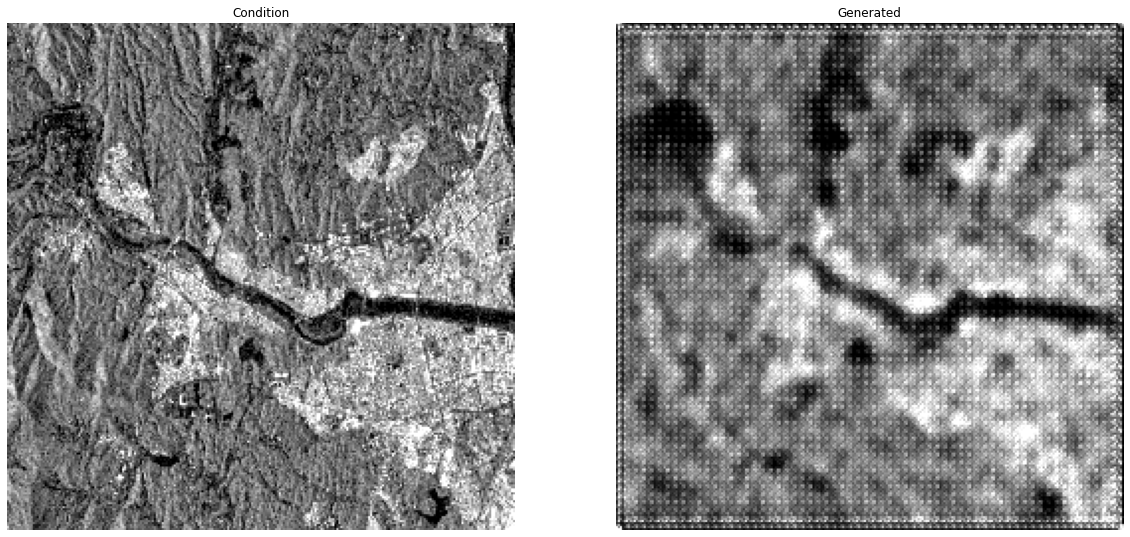

In [20]:
# File path
path=os.path.join(os.getcwd(), 'inference', '20m')
file_path = os.path.join(path,  'S1A_IW_GRDH_1SDV_20210105T092315_20210105T092344_036001_0437B7_42D51.tif')

# Load the saved generator model
result_dir = os.path.join(os.getcwd(), 'result', 'logs_8x8_0709_1551(code1)')
g_model_path = os.path.join(result_dir, 'd_model.h5')

if not os.path.exists(g_model_path):
    raise FileNotFoundError(f"Generator model not found at {g_model_path}")

# Load the generator model
g_model = load_model(g_model_path, compile=False)
print("Generator model loaded successfully.")

# Perform inference
output_image_path = os.path.join(path, 'inference_result.png')
perform_inference(g_model, file_path, save_path=output_image_path)